In [1]:
from numba import jit,prange
import numpy as np
import math
from scipy import interpolate

In [2]:
@jit(nopython=True)
def Orderparameter(data):
#    输入：data为向量，存储着瞬时磁场，向量的长度为总取样数，即瞬时磁场的个数
#    输出：OP为一个数字，在相应温度下的平均磁场强度
    OP=np.sum(data)/data.shape[0]
    return OP

In [3]:
@jit(nopython=True)
def Susceptibility_orderparameter(data,T,M,N):
#    输入：data为向量，存储着瞬时磁场，向量的长度为总取样数，即瞬时磁场的个数
#         T为一个数字，为Ising模型的温度，若为非Ising model，则取T=1
#         M,N分别为一个数字，是模型的空间大小
#    输出：SusOP为一个数字，在相应温度下的平均磁场强度
    k=1  #Boltamann常数
    beta=1/(k*T) 
    SusOP=beta*M*N*(np.sum(data*data)/data.shape[0]-np.power(Orderparameter(data),2)) 
    return SusOP

In [5]:
@jit(nopython=True)
def N_std(data):
#    计算诸如磁场这类均值与方差不相关的物理量的error的算法——直接计算标准差，这里计算的是磁场强度的error
#    输入：data为向量，存储着瞬时磁场，向量的长度为总取样数，即瞬时磁场的个数
#    输出：OPstd为一个数字，为data内所存物理量的标准偏差
    OPstd=np.std(data)
    return OPstd

In [6]:
@jit(nopython=True,parallel=True)
def jackknife_SusOP(data,T,M,N):
#    计算诸如比热容、敏感性（磁化率）这类均值与方差相关的物理量的error时采用jackknife算法，这里计算敏感性（磁化率，Susceptibility）的error
#    输入：data为向量，存储着瞬时磁场或瞬时能量，向量的长度为总取样数，即瞬时磁场的个数
#         T为一个数字，为Ising模型的温度，若为非Ising model，则取T=1
#         M,N分别为一个数字，是模型的空间大小
#    输出：SusOPstd为一个数字，为物理量的error
    SusOP=Susceptibility_orderparameter(data,T,M,N)
    Num=data.shape[0]
    dataOri=data
    SusOPsub=np.empty(shape=(Num,)) #设置向量时必须用类似（5,）来表达，若用（5,1）则还是二维数组
    for i in prange(Num):
        data=np.delete(data,i) #删除向量的某一元素
        SusOPsub[i]=Susceptibility_orderparameter(data,T,M,N)
        data=dataOri
    SusOPstd=math.sqrt(np.sum(np.power(SusOPsub-SusOP,2)))
    return SusOPstd

In [7]:
def jackknife_R(model,R): #输入模型空间构型的所有瞬态，即下面的configdata
#    计算诸如比热容、敏感性（磁化率）这类均值与方差相关的物理量的error时采用jackknife算法，这里计算相关长度（Correlation_length）的error
#    输入:model为三维array，第一维存储时间序列，第二和第三位存储空间维度——即行和列
#         method为1个数字，1表示使用单个0分量，2表示使用4个等效0分量
#        R为Correlation_length，为一个标量
#    输出:Rstd为一个数，为Correlation_length的error
    SamNum,M,N=model.shape #SamNum为时间序列的采样数，M为空间行数，N为空间列数
    modelOri=model
    Rsub=np.empty(shape=(SamNum,))
    for i in range(SamNum):
        model=np.delete(model,i,axis=0) #删除三维array在时间维上的切片
        Rsub[i]=Correlation_length(Correlation_function(model,1))
        model=modelOri
    Rstd=math.sqrt(np.sum(np.power(Rsub-R,2)))
    return Rstd

In [8]:
@jit(nopython=True,parallel=True)
def Fluctuation_space(model,data,situ):
#    适用范围：适用于具有周期性边界条件的二维Ising类模型和二维动力学模型在空间上的涨落分析，计算了尺度涨落。
#    输入：model为矩阵，存储模型的瞬时状态；
#         data为矩阵，为model在空间上3*3的扩展，这是由于目前版本的numba(0.44)不支持numpy.tile这个函数
#         situ表示输入模型的类型，“1”表示Ising类统计物理模型（1与-1两个状态），“2”表示动力学模型（数值连续）。       
#    过程输出：fluctuate为向量，存储取样框内所统计的物理量的热力学涨落的计算结果；(暂时废弃)
#         average为向量，存储取样框内所统计的物理量的均值；(暂时废弃)
#         fluctuateS为向量，存储取样框内所统计的物理量的尺度涨落的计算结果；
#         scale为向量，存储取样方框的尺寸。
#    最后输出：Slop为涨落指数
    M1,N1=model.shape
#    data=np.tile(model,(3,3)) #将model按3*3的构型复制9次，但是目前版本的numba(0.44)不支持numpy.tile，所以需要在主程序里添加这一步骤
    MaxSize=math.floor(min(M1,N1)/2) #决定取样框的最大尺寸 
    fluctuateS=np.empty(shape=(MaxSize,)) 
    average=np.empty(shape=(MaxSize,)) 
    avar=np.empty(shape=(MaxSize,))
    scale=np.arange(1,MaxSize+1)  #取样框尺寸的变化范围
    Total=M1*N1 
    if Total<=5000:
        Total=Total #扔框的次数
    elif Total>5000:
        Total=5000  #扔框的次数
    if situ==1:
        xup,yup=np.where(model==1) #np.where类似于matlab的find函数，返回符合条件的array的元素的行号与列号
        xdown,ydown=np.where(model==-1)
        TotNumUp=xup.shape[0]
        TotNumDown=xdown.shape[0]
        if TotNumUp>=TotNumDown: #统计向上（1）的spin的数量
            obj=1 
        elif TotNumUp<TotNumDown: #统计向下（-1）的spin的数量
            obj=-1 
    for i1 in prange(1,MaxSize+1):
        Sample=np.empty(shape=(Total,)) 
        Area=i1*i1 
        for i2 in prange(Total):
            Index1=np.random.randint(low=M1+1,high=2*M1+1,size=1) #注意：这两行随机数生成的代码分别返回的是一个元素的array。
            Index2=np.random.randint(low=N1+1,high=2*N1+1,size=1) 
            tempdata=data[Index1[0]:Index1[0]+i1,Index2[0]:Index2[0]+i1] #注意：array不能直接放入这里的切片中，必须将元素取出来为一个数放入切片中
            if situ==1: #spin类，比如Ising model
                x1,y1=np.where(tempdata==obj)
                Sample[i2]=x1.shape[0]/Area 
            elif situ==2: #动力学模型类，比如Ricker model
                Sample[i2]=np.sum(tempdata)/Area 
        average[i1-1]=np.mean(Sample) 
        avar[i1-1]=np.var(Sample) 
    fluctuateS=avar/(average*average) #尺度算法计算涨落
#    P=np.polyfit(np.log(scale),np.log(fluctuateS),1) #取对数后进行一阶线性拟合，但是numba目前的版本（0.43）不支持numpy.polyfit
#    Slop=P[0]
    return fluctuateS,scale

In [9]:
def Correlation_function(model,method):
#    输入:model为三维array，第一维存储时间序列，第二和第三位存储空间维度——即行和列
#         method为1个数字，1表示使用单个0分量，2表示使用4个等效0分量
#    输出：GF为一个向量，为相应温度下空间两点间的相关性函数

#    利用傅里叶变换计算卷积
    SamNum,M,N=model.shape #SamNum为时间序列的采样数，M为空间行数，N为空间列数
    Cum=np.zeros((M,N))
    phi=np.arange(1,101)/100*2*math.pi
    Size=math.floor(min(M,N)/2) 
    GF=np.zeros((Size,))
    modelY=np.empty((SamNum,M,N),dtype=complex) #预设data type为复数
    modelC=np.empty((SamNum,M,N))
    for i in range(SamNum):
        modelY[i,:,:]=np.fft.fft2(model[i,:,:]) #目前版本的numba（0.44）还不支持numpy.fft模块！
        modelC[i,:,:]=np.power(np.absolute(modelY[i,:,:]),2) 
        Cum=Cum+modelC[i,:,:] 
    GK=Cum/(SamNum*M*N) 
    if method==1: #认为fftshit后0分量在中心
        X=np.arange(-M/2,M/2)
        Y=np.arange(-N/2,N/2)
#        X,Y=np.meshgrid(XX,YY) 
        GK[0,0]=0 
        GR=np.fft.fftshift(np.fft.ifft2(GK)) #numpy的ifft2的结果会包含虚数部分，在应用时可直接将结果中的虚数部分忽略，只采用实数部分的结果。
        Fcircle=interpolate.interp2d(X,Y,GR,kind='cubic') #创建interpolate.interp2d这个class的一个实例。这里与matlab里的interp2不同，不需要输入一个meshgrid好的网格
        for j in range(Size):
            GF[j]=np.mean(Fcircle((j+1)*np.cos(phi),(j+1)*np.sin(phi))) #使用插值实例进行计算，由于返回的是一个array，所以需要整体的求平均
    elif method==2: #认为fftshit后0分量不在中心，而是4个分量构成中心
        X=np.concatenate((np.arange(-M/2,0),np.arange(1,M/2+1))) #与append类似的可将两个array合并的函数
        Y=np.concatenate((np.arange(-N/2,0),np.arange(1,N/2+1)))
#        X,Y=np.meshgrid(XX,YY)
        GK[0,0]=0 
        GK[M-1,0]=0 
        GK[0,N-1]=0 
        GK[M-1,N-1]=0 
        GR=np.fft.fftshift(np.fft.ifft2(GK))
        Fcircle=interpolate.interp2d(X,Y,GR,kind='cubic')
        for j in range(Size):
            GF[j]=np.mean(Fcircle((j+1)*np.cos(phi)-0.5,(j+1)*np.sin(phi)-0.5))
    return GF

In [10]:
def Correlation_length(GF): #这个方法对任意输入的GF并不好，因为有的相关性并达不到0.368，而且这种插值方式导致一个x对应2个y，即插值失败！
#    ！！！Correlation_length的这个函数需要重写！！！
#    输入:GF是一个向量，为相关性函数（G函数）
#    输出：R是一个数，为相关长度
    Size,=GF.shape #GF的长度若为5，则Size=5
    Scale=np.arange(Size) #接上面，从0到4
    GF_log=np.log(GF)
    Scale_log=np.log(Scale)
    interp_point=-1
    R_log=np.interp(interp_point,GF_log,Scale_log) #目前版本的numba（0.44）还不支持numpy.interp模块，貌似是因为不支持numpy.inner函数
    R=np.exp(R_log)
    return R

**Below:calculate the traditional statisical physical indexes**

In [13]:
def process_data():
    NumOfCase=72
    NumOfSam=1001
    M=64
    N=64
    Size=math.floor(min(M,N)/2)
    OP=np.empty((NumOfCase,),dtype=np.float32)
    SusOP=np.empty((NumOfCase,),dtype=np.float32)
    GF=np.empty((NumOfCase,Size),dtype=np.float32)
    R=np.empty((NumOfCase,),dtype=np.float32)
    PreS=np.empty((NumOfCase,),dtype=np.float32)
    PostS=np.empty((NumOfCase,),dtype=np.float32)
    SS=np.empty((NumOfCase,),dtype=np.float32)
    for i in range(NumOfCase):
        predata=np.empty((NumOfSam,M,N),dtype=np.float32)
        postdata=np.empty((NumOfSam,M,N),dtype=np.float32)
        configdata=np.empty((NumOfSam,M,N),dtype=np.float32)
        configspin=np.empty((NumOfSam,M,N),dtype=np.float32)
        magneticdata=np.empty((NumOfSam,),dtype=np.float32)
        preslop=np.empty((NumOfSam,),dtype=np.float32)
        postslop=np.empty((NumOfSam,),dtype=np.float32)
        spinslop=np.empty((NumOfSam,),dtype=np.float32)
        for j in range(NumOfSam):
            path='/home/user/ModelResult/Ricker2D_L64/'
            prefile='%03d_%05d_0.bin'%(i,j)
            postfile='%03d_%05d_1.bin'%(i,j)
            prefilename=path+prefile
            postfilename=path+postfile
            pretemp=np.fromfile(prefilename,dtype=np.float32)
            pretemp.shape=(M,N)
            predata[j,:,:]=pretemp #存储着模型每个采样点前一时刻的模型瞬态
            posttemp=np.fromfile(postfilename,dtype=np.float32)
            posttemp.shape=(M,N)
            postdata[j,:,:]=posttemp #存储着模型每个采样点后一时刻的模型瞬态
            configdata[j,:,:]=0.5*np.power(-1,j)*(postdata[j,:,:]-predata[j,:,:]) #存储着每个时刻类似瞬时磁场空间构型的矩阵
            magneticdata[j]=np.absolute(np.sum(configdata[j,:,:]))/(M*N) #存储着每个时刻类似瞬时磁场强度的标量
        OP[i]=Orderparameter(magneticdata)        
        SusOP[i]=Susceptibility_orderparameter(magneticdata,1,M,N)
#        GF[i,:]=Correlation_function(configdata,1)
#        R[i]=Correlation_length(GF[i,:])        
    return OP,SusOP

In [14]:
OP,SusOP=process_data()

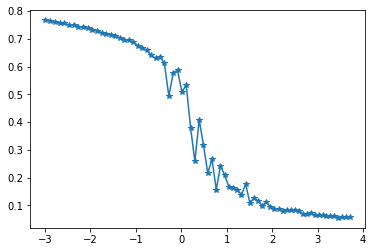

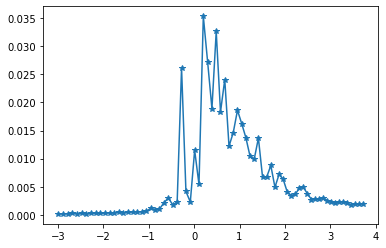

In [16]:
import matplotlib.pyplot as plt

L=64
ata=1
beta=0.125
gamma=1.75
StartB=np.float32(0.135) #初始噪音强度
EndB=np.float32(0.15) #终止噪音强度
Loop=np.linspace(StartB,EndB,num=72,dtype=np.float32)
RescaleLoop=(Loop-0.14131)/Loop*np.power(L,1/ata)
RescaleOP=np.power(L,beta/ata)*OP
RescaleSusOP=np.power(L,-gamma/ata)*SusOP
#RealLoop=np.concatenate((Loop[0:17],np.linspace(Loop[18],Loop[28],num=23,dtype=np.float32),Loop[29:63]))
f1=plt.figure(1)
plt.plot(RescaleLoop,RescaleOP,'-*')
plt.show()
f2=plt.figure(2)
plt.plot(RescaleLoop,RescaleSusOP,'-*')
plt.show()
#f3=plt.figure(3)
#plt.plot(RealLoop,R,'-*')
#plt.show()

**Below:calculate the scale-dependent fluctuation**

In [11]:
def process_data():
    NumOfCase=72
    NumOfSam=1 #currently. prcocess the first sample of the model results
    M=1024
    N=1024
    Size=math.floor(min(M,N)/2)
    OP=np.empty((NumOfCase,),dtype=np.float32)
    SusOP=np.empty((NumOfCase,),dtype=np.float32)
    GF=np.empty((NumOfCase,Size),dtype=np.float32)
    R=np.empty((NumOfCase,),dtype=np.float32)
    PreS=np.empty((NumOfCase,),dtype=np.float32)
    PostS=np.empty((NumOfCase,),dtype=np.float32)
    SS=np.empty((NumOfCase,),dtype=np.float32)
    for i in range(NumOfCase):
        predata=np.empty((NumOfSam,M,N),dtype=np.float32)
        postdata=np.empty((NumOfSam,M,N),dtype=np.float32)
        configdata=np.empty((NumOfSam,M,N),dtype=np.float32)
        configspin=np.empty((NumOfSam,M,N),dtype=np.float32)
        magneticdata=np.empty((NumOfSam,),dtype=np.float32)
        preslop=np.empty((NumOfSam,),dtype=np.float32)
        postslop=np.empty((NumOfSam,),dtype=np.float32)
        spinslop=np.empty((NumOfSam,),dtype=np.float32)
        for j in range(NumOfSam):
            path='/home/user/ModelResult/Ricker2D/'
            prefile='%03d_%05d_0.bin'%(i,j)
            postfile='%03d_%05d_1.bin'%(i,j)
            prefilename=path+prefile
            postfilename=path+postfile
            pretemp=np.fromfile(prefilename,dtype=np.float32)
            pretemp.shape=(M,N)
            predata[j,:,:]=pretemp #存储着模型每个采样点前一时刻的模型瞬态
            predatatemp=np.tile(predata[j,:,:],(3,3)) #把model的空间构型扩大为3*3的构型
            fluctuateS,scale=Fluctuation_space(predata[j,:,:],predatatemp,2)
            P=np.polyfit(np.log(scale),np.log(fluctuateS),1)
            preslop[j]=P[0]
            posttemp=np.fromfile(postfilename,dtype=np.float32)
            posttemp.shape=(M,N)
            postdata[j,:,:]=posttemp #存储着模型每个采样点后一时刻的模型瞬态
            postdatatemp=np.tile(postdata[j,:,:],(3,3))
            fluctuateS,scale=Fluctuation_space(postdata[j,:,:],postdatatemp,2)
            P=np.polyfit(np.log(scale),np.log(fluctuateS),1)
            postslop[j]=P[0]
            configdata[j,:,:]=0.5*np.power(-1,j)*(postdata[j,:,:]-predata[j,:,:]) #存储着每个时刻类似瞬时磁场空间构型的矩阵
            configspin[j,:,:]=np.where(configdata[j,:,:]>0,1,-1) #将configdata的结果转换为Ising的spin结构，大于0的赋值为1，不大于0的赋值为-1
            spintemp=np.tile(configspin[j,:,:],(3,3))
            fluctuateS,scale=Fluctuation_space(configspin[j,:,:],spintemp,1)
            P=np.polyfit(np.log(scale),np.log(fluctuateS),1)
            spinslop[j]=P[0]
#            magneticdata[j]=np.absolute(np.sum(configdata[j,:,:]))/(M*N) #存储着每个时刻类似瞬时磁场强度的标量

#        OP[i]=Orderparameter(magneticdata)        
#        SusOP[i]=Susceptibility_orderparameter(magneticdata,1,M,N)
#        GF[i,:]=Correlation_function(configdata,1)
#        R[i]=Correlation_length(GF[i,:])
        
        PreS[i]=np.mean(preslop)
        PostS[i]=np.mean(postslop)
        SS[i]=np.mean(spinslop)
        
#        OP[0]=Orderparameter(magneticdata)        
#        SusOP[0]=Susceptibility_orderparameter(magneticdata,1,M,N)
#        GF[0,:]=Correlation_function(configdata,1)
#        R[0]=Correlation_length(GF[0,:])
#    return OP,SusOP,GF,R
    return PreS,PostS,SS

In [12]:
PreS,PostS,SS=process_data()

LinAlgError: SVD did not converge in Linear Least Squares

In [13]:
import matplotlib.pyplot as plt

StartB=np.float32(0.12) #初始噪音强度
EndB=np.float32(0.18) #终止噪音强度
Loop=np.linspace(StartB,EndB,num=64,dtype=np.float32)
RealLoop=np.concatenate((Loop[0:17],np.linspace(Loop[18],Loop[28],num=23,dtype=np.float32),Loop[29:63]))
f1=plt.figure(1)
plt.plot(RealLoop,PreS,'-*')
plt.show()
f2=plt.figure(2)
plt.plot(RealLoop,PostS,'-*')
plt.show()
f3=plt.figure(3)
plt.plot(RealLoop,SS,'-*')
plt.show()

NameError: name 'PreS' is not defined

**Below:test the time required for calculating the scale-dependent fluctuation of 3 samples**

In [13]:
%timeit PreS,PostS,SS=process_data() #测试运算3个尺寸涨落的例子所需的时间，每个例子大概5min多点

16min 31s ± 10.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Below:vertify if the results of Ricker2D model contain inf and/or nan**

>When the noise level is high, the model results become "nan".

In [4]:
data=np.array([1,np.nan,2,np.inf,3,np.nan,np.inf,np.inf])
print(np.isnan(data).sum())
print(np.isinf(data).sum())

2
3


In [2]:
def is_nan_inf():
    NumOfCase=74
    NumOfSam=1001 #currently. prcocess the first sample of the model results
    M=1024
    N=1024
    prenannum=np.empty((NumOfCase,NumOfSam),dtype=np.int32) 
    preinfnum=np.empty((NumOfCase,NumOfSam),dtype=np.int32)
    postnannum=np.empty((NumOfCase,NumOfSam),dtype=np.int32)
    postinfnum=np.empty((NumOfCase,NumOfSam),dtype=np.int32)
    for i in range(NumOfCase):
        predata=np.empty((NumOfSam,M,N),dtype=np.float64)
        postdata=np.empty((NumOfSam,M,N),dtype=np.float64)
        for j in range(NumOfSam):
            path='/home/user/ModelResult/Ricker2D_float64/'
            prefile='%03d_%05d_0.bin'%(i,j)
            postfile='%03d_%05d_1.bin'%(i,j)
            prefilename=path+prefile
            postfilename=path+postfile
            pretemp=np.fromfile(prefilename,dtype=np.float64)
            pretemp.shape=(M,N)
            predata[j,:,:]=pretemp #存储着模型每个采样点前一时刻的模型瞬态
            prenannum[i,j]=np.isnan(predata[j,:,:]).sum()
            preinfnum[i,j]=np.isinf(predata[j,:,:]).sum()
            posttemp=np.fromfile(postfilename,dtype=np.float64)
            posttemp.shape=(M,N)
            postdata[j,:,:]=posttemp #存储着模型每个采样点后一时刻的模型瞬态
            postnannum[i,j]=np.isnan(postdata[j,:,:]).sum()
            postinfnum[i,j]=np.isinf(postdata[j,:,:]).sum()
    return prenannum,preinfnum,postnannum,postinfnum

In [3]:
prenannum,preinfnum,postnannum,postinfnum=is_nan_inf()

In [4]:
print(prenannum)
#np.savetxt("t1",prenannum)

[[      0       0       0 ...       0       0       0]
 [      0       0       0 ...       0       0       0]
 [      0       0       0 ...       0       0       0]
 ...
 [1048576 1048576 1048576 ... 1048576 1048576 1048576]
 [1048576 1048576 1048576 ... 1048576 1048576 1048576]
 [1048576 1048576 1048576 ... 1048576 1048576 1048576]]


In [5]:
x,y=np.where(prenannum>0)
print(x)
print(y)

[51 51 51 ... 73 73 73]
[ 927  928  929 ...  998  999 1000]


In [3]:
StartB=np.float32(0.12) #初始噪音强度
EndB=np.float32(0.18) #终止噪音强度
Loop=np.linspace(StartB,EndB,num=64,dtype=np.float32)
RealLoop=np.concatenate((Loop[0:17],np.linspace(Loop[18],Loop[28],num=23,dtype=np.float32),Loop[29:63]))
print(RealLoop[51])

0.15809524
